In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import vaex
import gizmo_analysis as ga
import sys
sys.path.append('../mock')
import allvariables
import beta
import getMasks
import getPhotometric
import getConversions
import getPlots
sys.path.append('../visualization')
import mollweide_plotting as pl
import nba
from astropy import units as u
from IPython.display import Image

In [2]:
# Set the parameters
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
#     'text.usetex': True,
    'axes.formatter.use_mathtext': False,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.top': True,
    'xtick.bottom': True,
    'xtick.minor.bottom': True,
    'ytick.right': True,
    'ytick.minor.right': True,
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'xtick.major.width': 1.1,
    'xtick.minor.width': 0.8,
    'ytick.major.width': 1.1,
    'ytick.minor.width': 0.8,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'figure.figsize': [6.0, 4.2]
})

## Access Mock Parameters

In [3]:
# Get the parameters from the config file
params = allvariables.getparamsnotebook()

# Define parameter names
param_names = [
        "snap", "sim", "sim_dir", "sat_id_dir", "rmin", "rmax", "sat_mask", "ananke_name", 
        "photo_sys", "cmd_magnames", "app_mag_lim_lo", "app_mag_lim_hi", 
        "abs_mag_lim_lo", "abs_mag_lim_hi", "ananke_r_max", "fsample"
]

# Initialize parameter dictionary
params_dict = {}

# Assign values to parameters and declare them locally
for param_name, param_value in zip(param_names, params):
    params_dict[param_name] = param_value
    locals()[param_name] = param_value

## Access Ananke Data

In [4]:
# Get the current working directory
current_dir = os.getcwd()

# Go back one directory (to 'src') and then to 'mock'
ananke_file_path = os.path.join(current_dir, "..", "mock", "survey.m12b_385.h5")
ananke_sat_file_path = os.path.join(current_dir, "..", "mock", "survey.m12b_385_sat.h5")
print(f"\nOpening data from: \n{ananke_file_path} \n{ananke_sat_file_path}")

# Check if the file exists
if os.path.exists(ananke_file_path):
    # Proceed with opening the file
    survey = vaex.open(ananke_file_path)
else:
    print(f"{ananke_file_path} file does not exist.")
    
# Check if the file exists
if os.path.exists(ananke_sat_file_path):
    # Proceed with opening the file
    survey_sat = vaex.open(ananke_sat_file_path)
else:
    print(f"{ananke_sat_file_path} file does not exist.")


Opening data from: 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.m12b_385.h5 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.m12b_385_sat.h5


In [5]:
# Print all the columns
column_names = survey.column_names
print(column_names)

['age', 'alpha', 'calcium', 'carbon', 'dec', 'dform', 'dmod', 'feh', 'glat', 'glon', 'grav', 'helium', 'lsst_gmag', 'lsst_gmag_Err', 'lsst_gmag_Intrinsic', 'lsst_gmag_Sig', 'lsst_imag', 'lsst_imag_Err', 'lsst_imag_Intrinsic', 'lsst_imag_Sig', 'lsst_rmag', 'lsst_rmag_Err', 'lsst_rmag_Intrinsic', 'lsst_rmag_Sig', 'lsst_umag', 'lsst_umag_Err', 'lsst_umag_Intrinsic', 'lsst_umag_Sig', 'lsst_ymag', 'lsst_ymag_Err', 'lsst_ymag_Intrinsic', 'lsst_ymag_Sig', 'lsst_zmag', 'lsst_zmag_Err', 'lsst_zmag_Intrinsic', 'lsst_zmag_Sig', 'lum', 'mact', 'magnesium', 'mtip', 'mub', 'mudec', 'mul', 'mura', 'neon', 'nitrogen', 'oxygen', 'parentid', 'partid', 'pi', 'px', 'py', 'pz', 'ra', 'rad', 'silicon', 'smass', 'sulphur', 'teff', 'vr', 'vx', 'vy', 'vz']


### Apparent Magnitude

In [6]:
# Extract apparent magnitudes without satellite
app_g_mag_sat = survey_sat.lsst_gmag.to_numpy()
app_r_mag_sat = survey_sat.lsst_rmag.to_numpy()
app_i_mag_sat = survey_sat.lsst_imag.to_numpy()
app_u_mag_sat = survey_sat.lsst_umag.to_numpy()
app_y_mag_sat = survey_sat.lsst_ymag.to_numpy()
app_z_mag_sat = survey_sat.lsst_zmag.to_numpy()

In [7]:
# Declare min and max values
mag_min = app_mag_lim_lo
mag_max = app_mag_lim_hi

# Create a combined boolean mask (a single mask is used to maintain consistent shape)
mask = ((app_g_mag_sat >= mag_min) & (app_g_mag_sat <= mag_max) & 
        (app_r_mag_sat >= mag_min) & (app_r_mag_sat <= mag_max) &
        (app_i_mag_sat >= mag_min) & (app_i_mag_sat <= mag_max) &
        (app_u_mag_sat >= mag_min) & (app_u_mag_sat <= mag_max) &
        (app_y_mag_sat >= mag_min) & (app_y_mag_sat <= mag_max) &
        (app_z_mag_sat >= mag_min) & (app_z_mag_sat <= mag_max))

# Apply masks to filter out values outside the set limits
app_g_mag_sat = app_g_mag_sat[mask]
app_r_mag_sat = app_r_mag_sat[mask]
app_i_mag_sat = app_i_mag_sat[mask]
app_u_mag_sat = app_u_mag_sat[mask]
app_y_mag_sat = app_y_mag_sat[mask]
app_z_mag_sat = app_z_mag_sat[mask]

### Absolute Magnitude

In [8]:
# Extract the radial distance as parsecs
rad_distance_sat = survey_sat.rad.to_numpy() * 1000

In [9]:
# Apply mask to distance
rad_distance_sat = rad_distance_sat[mask]

In [10]:
# Extract absolute magnitudes without satellite
g_mag_sat = getConversions.app2abs(app_g_mag_sat, rad_distance_sat)
r_mag_sat = getConversions.app2abs(app_r_mag_sat, rad_distance_sat)
i_mag_sat = getConversions.app2abs(app_i_mag_sat, rad_distance_sat)
u_mag_sat = getConversions.app2abs(app_u_mag_sat, rad_distance_sat)
y_mag_sat = getConversions.app2abs(app_y_mag_sat, rad_distance_sat)
z_mag_sat = getConversions.app2abs(app_z_mag_sat, rad_distance_sat)

## Adding Photometric Error

In [11]:
# Add the sigma value to each apparent magnitude
app_g_mag_sat_err = app_g_mag_sat + getPhotometric.getSigmaVisit('g', app_g_mag_sat)
app_r_mag_sat_err = app_r_mag_sat + getPhotometric.getSigmaVisit('r', app_r_mag_sat)
app_i_mag_sat_err = app_i_mag_sat + getPhotometric.getSigmaVisit('i', app_i_mag_sat)
app_u_mag_sat_err = app_u_mag_sat + getPhotometric.getSigmaVisit('u', app_u_mag_sat)
app_y_mag_sat_err = app_y_mag_sat + getPhotometric.getSigmaVisit('y', app_y_mag_sat)
app_z_mag_sat_err = app_z_mag_sat + getPhotometric.getSigmaVisit('z', app_z_mag_sat)

In [12]:
error_array = getPhotometric.getSigmaRand('g', app_g_mag_sat)

In [13]:
print(error_array)
print(min(error_array))
print(max(error_array))

[0.03691901 0.01211195 0.36468884 ... 0.19102468 0.1698922  0.17439333]
0.0008319475
1.0888652


Here I am calculating absolute magnitude from apparent magnitude with errors. I could also calculate the error using getPhotometric error itself, but I'm not sure with method is correct. 

In [14]:
# Extract absolute magnitudes without satellite and with error
g_mag_sat_err = getConversions.app2abs(app_g_mag_sat_err, rad_distance_sat)
r_mag_sat_err = getConversions.app2abs(app_r_mag_sat_err, rad_distance_sat)
i_mag_sat_err = getConversions.app2abs(app_i_mag_sat_err, rad_distance_sat)
u_mag_sat_err = getConversions.app2abs(app_u_mag_sat_err, rad_distance_sat)
y_mag_sat_err = getConversions.app2abs(app_y_mag_sat_err, rad_distance_sat)
z_mag_sat_err = getConversions.app2abs(app_z_mag_sat_err, rad_distance_sat)

## Color Magnitude Diagram

In [15]:
# Calculate g - r
g_minus_r_sat = app_g_mag_sat - app_r_mag_sat

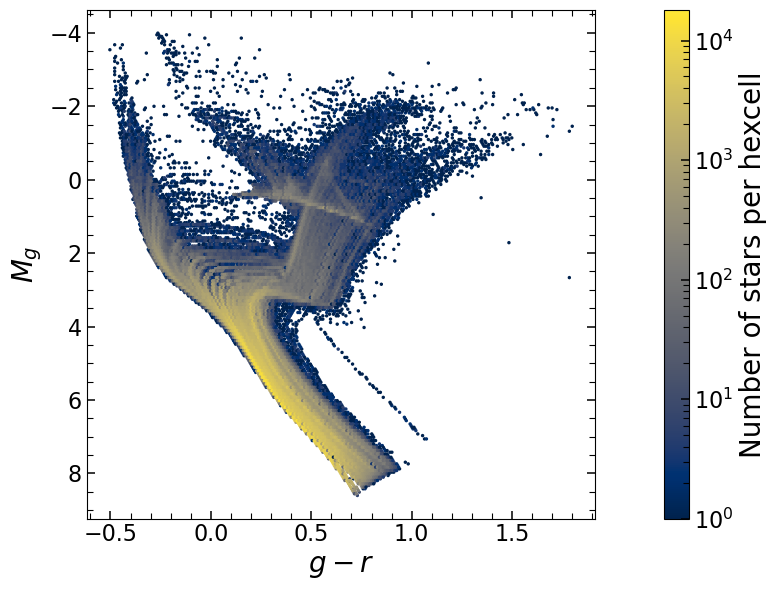

In [16]:
# Create color magnitude diagram
getPlots.colormagplot(g_minus_r_sat, g_mag_sat)

In [17]:
# Calculate g - r with error
g_minus_r_sat_err = app_g_mag_sat_err - app_r_mag_sat_err

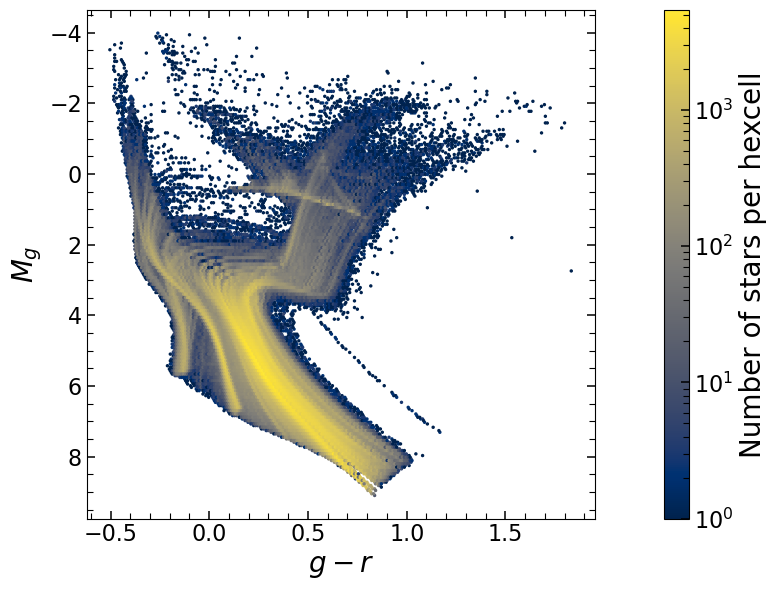

In [18]:
# Create color magnitude diagram with error valeus
getPlots.colormagplot(g_minus_r_sat_err, g_mag_sat_err)

## Density Profile

In [19]:
# Extract distance
anankeRadialSat = survey_sat.rad.to_numpy()
anankeRadialSatErr = anankeRadialSat[mask]

In [20]:
# Calculate density parameters
anankeEdgesSat, anankeDensitySat = getPlots.densityParams(anankeRadialSat, bins=200, rmin=rmin, rmax=rmax)
anankeEdgesSatErr, anankeDensitySatErr = getPlots.densityParams(anankeRadialSatErr, bins=200, rmin=rmin, rmax=rmax)

In [21]:
# Apply interpolation to each dataset
ananke_x_interp_sat, ananke_y_interp_sat = getPlots.interpolate_density(anankeEdgesSat[:-1], anankeDensitySat)
ananke_x_interp_sat_err, ananke_y_interp_sat_err = getPlots.interpolate_density(anankeEdgesSatErr[:-1], anankeDensitySatErr)

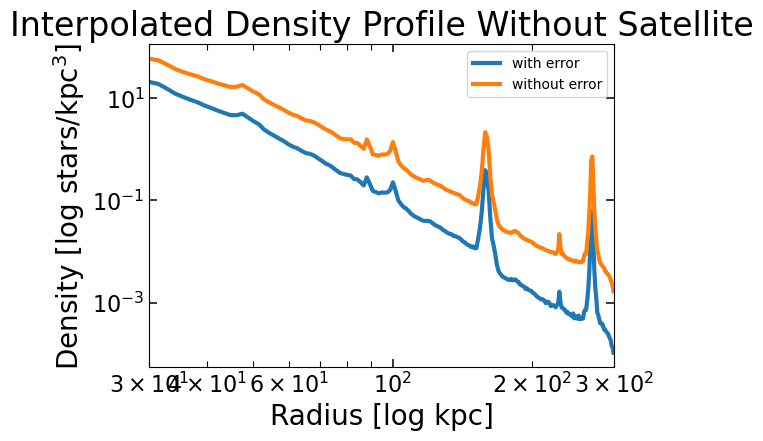

In [22]:
# Plot the density profile with interpolated values
fig, ax = plt.subplots()
ax.loglog(ananke_x_interp_sat_err, ananke_y_interp_sat_err, label='with error')
ax.loglog(ananke_x_interp_sat, ananke_y_interp_sat, label='without error')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.legend()
plt.title('Interpolated Density Profile Without Satellite')
plt.show()

## Proper Motion Plots

In [23]:
# Extract proper motions
mub = survey_sat.mub.to_numpy()      # glat 
mul = survey_sat.mul.to_numpy()      # glon
mura = survey_sat.mura.to_numpy()    # ra
mudec = survey_sat.mudec.to_numpy()  # dec

In [24]:
# Extract pos and vel
anankePosSat = np.stack((survey_sat.px.to_numpy(), survey_sat.py.to_numpy(), survey_sat.pz.to_numpy())).T
anankeVelSat = np.stack((survey_sat.vx.to_numpy(), survey_sat.vy.to_numpy(), survey_sat.vz.to_numpy())).T

In [25]:
# Apply kinematics 
f = 1* (u.km/u.s).to(u.kpc/u.Gyr)
kinematics1_ananke_sat = nba.kinematics.Kinematics(anankePosSat, anankeVelSat)
pos_galactic_ananke_sat = kinematics1_ananke_sat.pos_cartesian_to_galactic()
vel_galactic_ananke_sat = kinematics1_ananke_sat.vel_cartesian_to_galactic()

In [ ]:
# fig_ananke_sat_proper = f"ananke_mollweide_sat_proper.png"
# pl.mollweide_projection(pos_galactic_ananke_sat[0]*180/np.pi, pos_galactic_ananke_sat[1]*180/np.pi, mub, mul, 
#                         sim_dir=sim_dir, bmin=0, bmax=2000, nside=40, smooth=5, figname=fig_ananke_sat_proper)

In [ ]:
# Image(fig_ananke_sat_proper)